In [1]:
import pyproj
import verde as vd
import harmonica as hm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

from eql_source_layouts import fetch_airborne_gravity, block_reduced_points

In [2]:
# Fetch airborne gravity data
data = fetch_airborne_gravity()

In [10]:
# Compute the gravity disturbance by removing the
# normal gravity from the meassured full gravity
normal_gravity = hm.normal_gravity(
    data.latitude.values, data.ellipsoidal_height.values
)
data["disturbance"] = data.full_gravity - normal_gravity

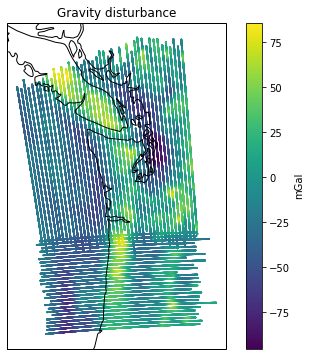

In [14]:
# Plot gravity disturbance on observation points
plt.figure(figsize=(7, 6))
ax = plt.axes(projection=ccrs.Mercator())
ax.set_title("Gravity disturbance")
ax.coastlines(resolution="50m")
tmp = ax.scatter(
    data.longitude,
    data.latitude,
    c=data.disturbance,
    s=0.5,
    transform=ccrs.PlateCarree()
)
plt.colorbar(tmp).set_label("mGal")
plt.show()

In [15]:
# Project data using Mercator projection because the gridder
# works in Cartesian coordinate system
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(
    data.longitude.values, data.latitude.values
)

In [16]:
coordinates = (data.easting, data.northing, data.ellipsoidal_height)

region = vd.get_region(coordinates)
print("Easting range: {}m".format(region[1] - region[0]))
print("Northing range: {}m".format(region[3] - region[2]))

Easting range: 536321.7011943497m
Northing range: 798654.0473126778m


In [20]:
points = block_reduced_points(
    coordinates,
    depth_factor=1,
    static_shift=500,
    k_nearest=10,
    spacing=10000
)

In [ ]:
gridder = hm.EQLHarmonic(points=points)
gridder.fit(coordinates, data.disturbance)